## Imports

In [49]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:

from sim import *

import numpy as np
import pandas as pd

from balance import *

import plotly.io as pio
pio.renderers.default = 'notebook_connected'
import plotly.graph_objects as go
import plotly.express as px


## Analyse results

### Main class


In [179]:
class AnalyseSimulation:
    def __init__(self, data, idx):
        self.data = data
        self.idx = idx
        self.n = len(data.initial_distr.T)

    def graph(self):
        return read_graph(self.data.adjacency, self.data.friendliness)

    def plot_coins(self):
        sim = self.data
        plt.plot(np.cumsum(sim.coins))
        plt.legend(range(self.n))

    def plot_mean(self):
        sim = self.data
        # alpha is transparency of graph lines
        plt.plot(sim.mean_list, alpha=0.5)
        plt.title(f"Mean/Iter, sim {self.idx}")
        plt.xlabel("Iteration")
        plt.ylabel("Mean")
        plt.legend(range(self.n))

    def plot_std(self):
        sim = self.data
        # alpha is transparency of graph lines
        plt.plot(sim.std_list, alpha=0.5)
        plt.title(f"StdDev/Iter, sim {self.idx}")
        plt.xlabel("Iteration")
        plt.ylabel("Standard Deviation")
        plt.legend(range(self.n))


    def plot_distr(self, step, title=None):
        sim = self.data
        # alpha is transparency of graph lines
        plt.plot(np.linspace(0, 1, BIAS_SAMPLES), sim.distrs[step].T)

        if title is None:
            title = f"Distribution step {step}"

        plt.title(f"{title}, sim {self.idx}")
        plt.xlabel("$\\theta$")
        plt.ylabel("Probability")
        plt.legend(range(self.n))

    def plotly_distr(self):
        theta = np.linspace(0, 1, BIAS_SAMPLES)

        df = pd.DataFrame([(v, theta[i], node, step) 
                            for step, ds in enumerate(self.data.distrs) 
                            for node, row in enumerate(ds) 
                            for i, v in enumerate(row)], 
                    columns=["y", 'theta', 'node', 'step'])

        fig = px.line(df, x="theta", y="y", animation_frame="step", 
                    color="node", hover_name="node",
                )
        fig.update_traces(opacity=0.1)
        fig.show()

    def plot_initial_distr(self):
        self.plot_distr(0, "Initial distribution")

    def plot_final_distr(self):
        self.plot_distr(-1, "Final distribution")


### Actual results

In [71]:
def parse_result(results):
    results_dict = {}
    for i, label in enumerate(["steps", "asymptotic", "coins", "mean_list", "std_list",
                         "final_distr", "initial_distr", "friendliness", "adjacency", "distrs"]):
        results_dict[label] = results[i]

    for k in ["adjacency", "friendliness", "final_distr", "initial_distr", "mean_list", "std_list", "distrs"]:
        results_dict[k] = np.asarray(results_dict[k])

    return SimResults(**results_dict)


def read_results(filename):
    with open(filename, 'r') as f:
        top = json.load(f)
        res = top['res']
        args = top['args']
        sim_args = top['sim_params']

        print("sim params ------")
        for k, v in sim_args.items():
            print(f"{k} - {v}")

        return [AnalyseSimulation(parse_result(r), i) for i, r in enumerate(res)]

In [187]:
res = read_results("output/res-2022_04_30-12_13_43.json")

sim = res[0]

sim params ------
prior_mean - [0.7498557642123131, 0.6966702473080252]
prior_sd - [0.26635695968394746, 0.2373705200744255]
max_steps - 1000
true_bias - 0.5
tosses_per_iteration - 10
learning_rate - 0.25
asymptotic_learning_max_iters - 10
DWeps - 1
disruption - 0
log - True


In [175]:
pd.DataFrame(sim.data.mean_list[500:,-1]).describe()

,0
count,500.000000
mean,0.593202
std,0.050570
min,0.324939
25%,0.587623
50%,0.598318
75%,0.601898
max,0.834388


In [188]:
sim.plotly_distr()

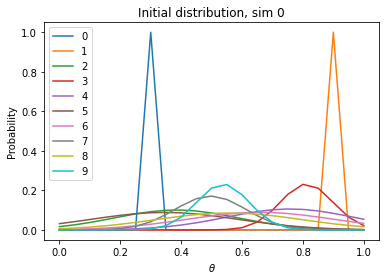

In [136]:
sim.plot_initial_distr()

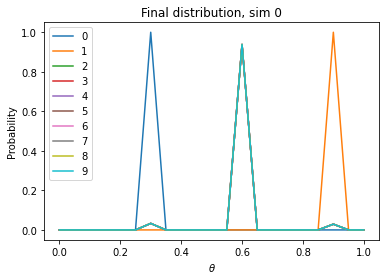

In [137]:
sim.plot_final_distr()

,0
count,800.000000
mean,0.532352
std,0.050153
min,0.301777
25%,0.535013
50%,0.554537
75%,0.560058
max,0.562463


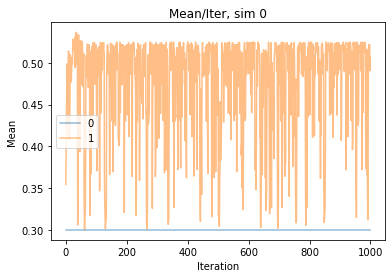

In [178]:
sim.plot_mean()


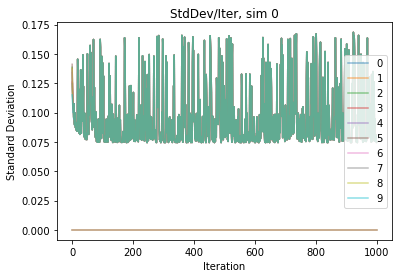

In [139]:
sim.plot_std()

### Profiling

In [ ]:
# %%
g = pair_of_allies()
init_simulation(g, prior_mean=np.array((0.25, 0.75)),
                prior_sd=np.array([fwhm_to_sd(0.4)] * 2))

draw_graph(g)
# %%
g = complete_graph_of_enemies(2)

with cProfile.Profile() as pr:
    seed(42)
    res = run_simulation(g,
                         max_steps=2000,
                         prior_mean=np.array((0.25, 0.75)),
                         prior_sd=np.array([fwhm_to_sd(0.4)] * 2),
                         tosses_per_iteration=10
                         )
    steps, asymptotic, coins, mean_std, distr, initial_distr = res
mean_std = np.array(mean_std)
steps, asymptotic

# 0.530 seconds (677 iterations) without graphtool storing priors
# 3.254 seconds (677 iterations) with graphtool

# %%
%%time
g = complete_graph_of_random(3)

init_simulation(g)
res = run_simulation(g, max_steps=1000)

# %%
g.vp.prior_mean.a


# %%
#pr.print_stats()

# %%
last_results_fname = "output/res-{}.json".format(timestamp())
dump_json(res, last_results_fname)

res_read = read_results(last_results_fname)

# works :)


# %%
last_graph_fname = "output/graph-{}.gt".format(timestamp())
g.save(last_graph_fname)

g = gt.load_graph(last_graph_fname)

draw_graph(g)

# %%
%%time
res = do_ensemble(runs=10, gen_graph=lambda: complete_graph_of_enemies(10), sim_params={"max_steps": 1000})


# %%
# %%time
# res = do_ensemble_parallel(runs=10, gen_graph=lambda: complete_graph_of_enemies(10), sim_params={"max_steps": 1000})



# %%
with cProfile.Profile() as pr:
    res = do_ensemble(runs=20, gen_graph=lambda: complete_graph_of_random(15), sim_params={"max_steps": 10000})

# %%
pr.print_stats()

# %%
%%time
res = do_ensemble(runs=20, gen_graph=lambda: complete_graph_of_friends(10), sim_params={"max_steps": 1000})

# %%


## Cluster stuff

In [ ]:
def draw_cluster_graph_nick(g):
    edge_color_map = {-1.0: (1, 0, 0, 1),  # red
                        1.0: (0, 1, 0, 1),  # green
                        0.0: (0, 0, 0, 0)}  # black

    edge_color = g.new_ep('vector<double>')
    for f, e in zip(g.ep.friendliness, g.edges()):
        edge_color[e] = edge_color_map[f]

    cluster_ids = g.new_vp('int')
    cluster_ids.a = get_clusters_nick(friendliness_mat(g))


    gt.graph_draw(g,vertex_text=cluster_ids,
                    edge_color=edge_color,
                    output_size=(150, 150))

In [59]:
def get_clusters_nick(adj):
    adj2 = adj.copy()
    np.fill_diagonal(adj2, 1)  # diagonal entries must be >0 for the below trick to work
    group_id = np.full(adj.shape[0], adj.shape[0], dtype=np.int32)
    
    # group friends into the same group
    checked_nodes = set()
    for i in range(adj.shape[0]):
        if i in checked_nodes:
            continue
        group_id[i] = i
        queued_friends = {i}  # this is a set
        while queued_friends:
            current_node = queued_friends.pop()
            
            friends = np.nonzero(adj2[current_node] > 0)[0]
            new_friends = [j for j in friends if not j in checked_nodes]
            for friend in new_friends:
                group_id[friend] = i
            queued_friends.update(new_friends)
            checked_nodes.add(current_node)
        
    # now check for enemies. if two nodes in the same group are enemies, then the network is unbalanced
    # for i in range(adj.shape[0]-1):
    #     enemies = adj2[i] < 0
    #     has_contradiction = np.any(group_id[i] == group_id[enemies])
    #     if has_contradiction:
    #         return 0
    
    enemies = adj2 < 0
    has_contradiction = np.any((group_id.reshape(-1,1) == group_id)[enemies])
    if has_contradiction:
        return 0
        
    # now check if we can minimise the number of unique group id
    no_change = False
    while not no_change:
        no_change = True
        unique_id = np.unique(group_id)
        combo = []
        for i in range(unique_id.shape[0]):
            for j in range(i+1, unique_id.shape[0]):
                combo.append((unique_id[i], unique_id[j]))
        # combo = itertools.combinations(unique_id, 2)
        for u, v in combo:
            nodes1 = np.nonzero(group_id == u)[0]
            nodes2 = np.nonzero(group_id == v)[0]
            can_merge = True
            for i in nodes1:
                for j in nodes2:
                    if adj2[i,j] < 0:
                        can_merge = False
                        break
                if not can_merge:
                    break
            
            if can_merge:
                no_change = False
                group_id[nodes2] = u
                break
    
    return group_id

In [69]:
def get_clusters(g):
    cluster_ids = g.new_vertex_property('int')
    cluster_ids.a = np.full(g.num_vertices(), -1)

    for v in g.iter_vertices():
        pass

    return cluster_ids


In [72]:
draw_cluster_graph(g)

KeyError: ('v', 'cluster_id')

Balance.WEAKLY


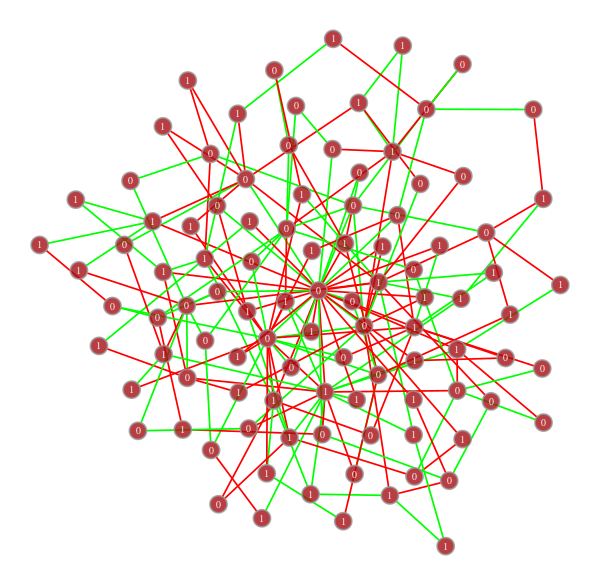

In [93]:
g = gen_balanced_type(Balance.STRONGLY, n=100, m=2)

print(test_graph_balance(g))
draw_cluster_graph(g)

In [77]:
draw_cluster_graph_nick(g)

NameError: name 'draw_cluster_graph_nick' is not defined

In [54]:
-(adjacency_mat(g) - 1)

array([[ 1., -0., -0.,  1.,  1., -0., -0., -0., -0., -0.],
       [-0.,  1., -0., -0.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-0., -0.,  1., -0., -0.,  1., -0.,  1.,  1.,  1.],
       [ 1., -0., -0.,  1., -0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1., -0., -0.,  1., -0.,  1.,  1.,  1.,  1.],
       [-0.,  1.,  1.,  1., -0.,  1.,  1.,  1., -0.,  1.],
       [-0.,  1., -0.,  1.,  1.,  1.,  1., -0.,  1.,  1.],
       [-0.,  1.,  1.,  1.,  1.,  1., -0.,  1.,  1.,  1.],
       [-0.,  1.,  1.,  1.,  1., -0.,  1.,  1.,  1., -0.],
       [-0.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -0.,  1.]])

In [52]:
friendliness_mat(g)

array([[ 0., -1., -1.,  0.,  0.,  1.,  1.,  1., -1.,  1.],
       [-1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0., -1.,  1.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.],
       [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])